In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
import pandas as pd
from time import sleep
from collections import defaultdict

warnings.filterwarnings(action='ignore')

from tqdm import tqdm
from crawler.utils.daily_reports import DailyReports

%matplotlib inline

In [3]:
elastic_info = {
    'host': 'https://crawler-es.cloud.ncsoft.com:9200', 
    'auth': 'ZWxhc3RpYzpzZWFyY2hUMjAyMA=='
}

reports = DailyReports(**elastic_info, encoded_auth=True)

reports.set_plt_font()

<Figure size 1440x1440 with 0 Axes>

# 인덱스 수량

In [4]:
date_range = '2021-01-01~2021-03-31'
date_range = '2020-01-01~2020-12-31'

year = date_range.split('-')[0]

neddle = set([
    'naver', 
    year, 
    date_range.split('~')[1].split('-')[0]
])

In [5]:
index_size = [x for x in reports.state['size'] if set(x['index'].split('-')).intersection(neddle) == neddle]

In [6]:
df_size = pd.DataFrame(index_size).set_index('index')

df_size['count'] = df_size['count'].astype(float)

reports.custom_display(df_size.describe().T)

,count,mean,std,min,25%,50%,75%,max
count,9,415638,399870,37249,148942,211370,506187,1286504


<AxesSubplot:>

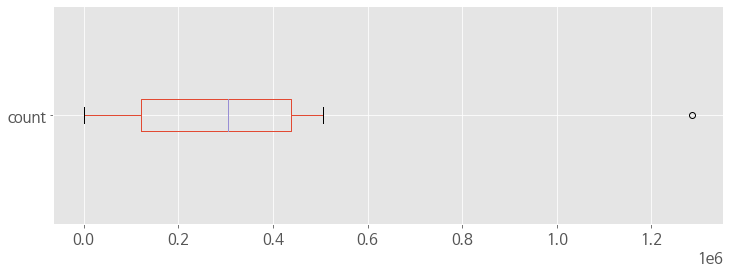

In [7]:
df_size.describe().boxplot(figsize=(12, 4), vert=False)

In [8]:
reports.custom_display(df_size)

,count
index,
crawler-naver-economy-2020,780359
crawler-naver-international-2020,148942
crawler-naver-it-2020,148438
crawler-naver-living-2020,211370
crawler-naver-opinion-2020,37249
crawler-naver-politics-2020,506187
crawler-naver-society-2020,1286504
crawler-naver-sports-2020,433626
crawler-naver-tv-2020,188070


<AxesSubplot:xlabel='index'>

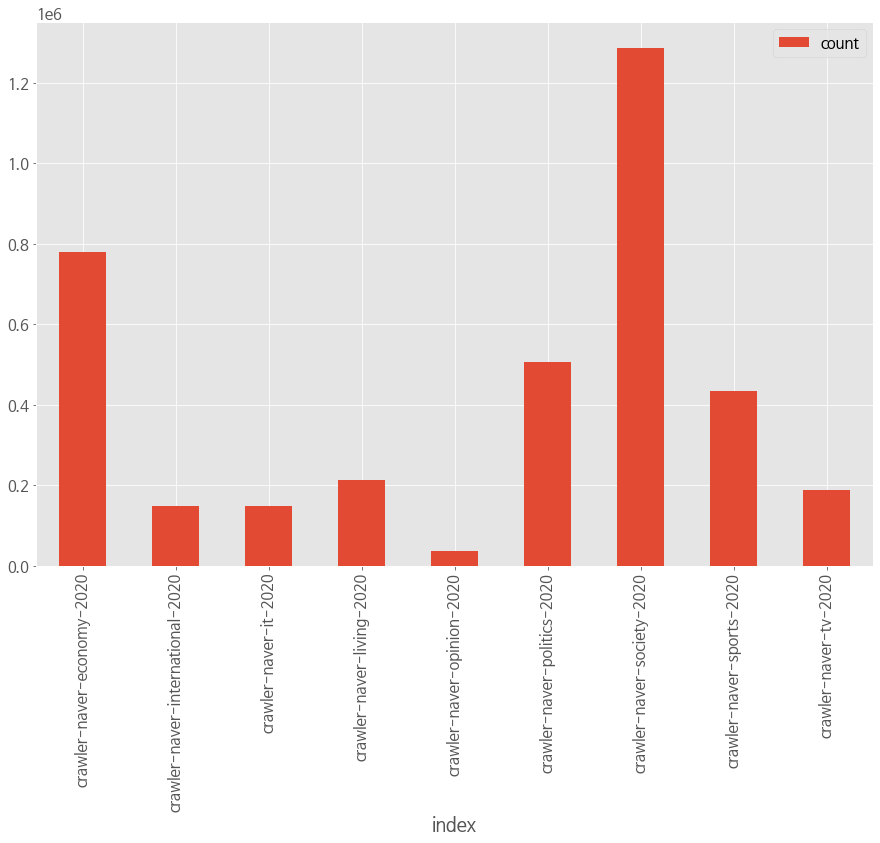

In [9]:
df_size.plot(kind='bar', figsize=(15, 10))

# 날짜별 기사 

In [10]:
index_list = [x for x in reports.state['list'] if set(x.split('-')).intersection(neddle) == neddle]

data = reports.get_index_histogram(index_list=','.join(index_list), date_range=date_range)
    
df_date = pd.DataFrame(data).fillna(0)

In [11]:
reports.custom_display(df_date)

,society,economy,politics,sports,living,tv,international,it,opinion
2020-06-30,11,0,0,0,33,0,6,18,0
2020-07-01,7328,7236,3646,0,1928,0,1076,1361,280
2020-07-02,6455,6627,3428,0,1405,0,1120,1206,277
2020-07-03,4883,4402,3505,0,1112,0,893,734,196
2020-07-04,1251,681,723,0,422,0,466,110,91
2020-07-05,2121,1823,1024,0,553,0,406,318,106
2020-07-06,5454,5762,3317,0,1278,0,864,1035,277
2020-07-07,5953,6353,3416,0,1218,0,1009,1019,261
2020-07-08,6056,5636,4219,0,1356,0,992,1248,281
2020-07-09,6443,6089,3520,0,1207,0,991,1030,276


In [12]:
reports.custom_display(df_date.describe())

,society,economy,politics,sports,living,tv,international,it,opinion
count,191,191,191,191,191,191,191,191,191
mean,6695,4072,2638,2261,1102,979,777,775,194
std,3155,2291,1387,1394,494,592,302,439,87
min,0,0,0,0,0,0,0,0,0
25%,3676,1764,1256,1586,570,660,480,358,96
50%,8120,5121,3028,2458,1301,1381,886,947,245
75%,9290,5919,3624,3133,1453,1473,976,1124,265
max,11961,7514,5617,6423,1975,1766,2009,1495,296


<AxesSubplot:>

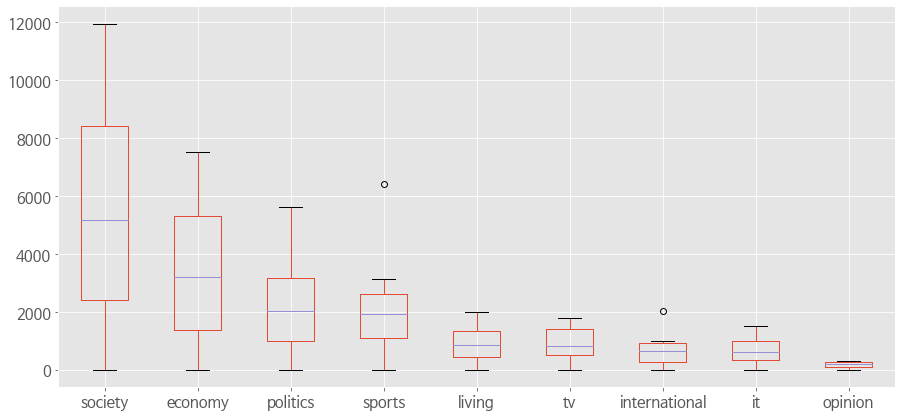

In [13]:
order = df_date.describe().median().sort_values(ascending=False)
df_date.describe()[order.index].boxplot(figsize=(15, 7))

<AxesSubplot:>

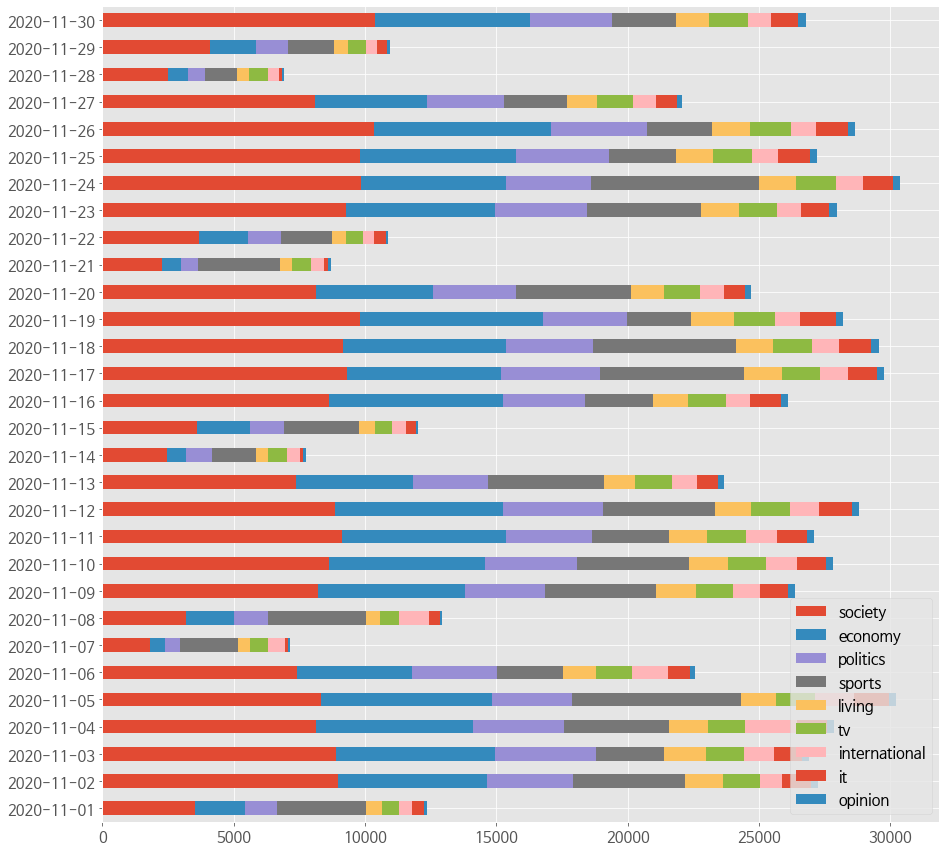

In [14]:
# TODO: 한달 단위 그래프 표시 
month_st, month_en = 11, 12

mask = (f'{year}-{month_st:02}-01' <= df_date.index) & (df_date.index < f'{year}-{month_en:02}-01')
display(df_date[ mask ].plot(kind='barh', stacked=True, figsize=(15, 15)))

# 백필 현재 위치 

In [15]:
index_list = [x for x in reports.state['list'] if set(x.split('-')).intersection(neddle) == neddle]

data = reports.get_category_min_date(index_list=','.join(index_list))

In [16]:
df_backfill_pos = pd.DataFrame(data).set_index(['section', 'category'])

In [17]:
df_backfill_pos

date
section       category              
society       사회/사회일반     2020-07-17
              사회/지역       2020-06-30
              사회/사건사고     2020-06-30
              사회/식품의료     2020-06-30
              사회/인물       2020-06-30
              사회/교육       2020-06-30
economy       경제/경제 일반    2020-06-30
              경제/산업/재계    2020-06-30
              경제/증권       2020-06-30
              경제/부동산      2020-06-30
              경제/금융       2020-06-30
              경제/생활경제     2020-06-30
              경제/중기/벤처    2020-06-30
              경제/글로벌 경제   2020-06-30
politics      정치/정치일반     2020-06-30
              정치/국회정당     2020-06-30
              정치/국방외교     2020-06-30
              정치/청와대      2020-06-30
              정치/행정       2020-06-30
              정치/북한       2020-06-30
sports        스포츠/야구      2020-07-31
              스포츠/해외축구    2020-07-31
              스포츠/농구      2020-07-31
              스포츠/축구      2020-07-31
              스포츠/골프      2020-07-31
              스포츠/배구      2020-07-31
              스포츠/게임      2020-07-31
              스포츠/해외야구    2020-07-31
              스포츠/스포츠-일반  2020-07-31
living        생활/일반       2020-06-30
              생활/날씨       2020-06-30
              생활/건강정보     2020-06-30
              생활/자동차시승기   2020-06-30
              생활/여행/레저    2020-06-30
              생활/공연전시     2020-06-30
              생활/책        2020-06-30
              생활/종교       2020-06-30
              생활/패션뷰티     2020-06-30
tv            TV          2020-07-31
international 세계/일반       2020-06-30
              세계/미국중남미    2020-06-30
              세계/아시아호주    2020-06-30
              세계/유럽       2020-06-30
              세계/중동아프리카   2020-06-30
it            IT/IT 일반    2020-06-30
              IT/과학 일반    2020-06-30
              IT/게임/리뷰    2020-06-30
              IT/통신/뉴미디어  2020-06-30
              IT/인터넷/SNS  2020-06-30
              IT/모바일      2020-06-30
              IT/컴퓨터      2020-06-30
              IT/보안/해킹    2020-06-27
opinion       오피니언        2020-06-30